In [104]:
import os
import numpy   as np
import pandas as pd
import seaborn as sns

import time

import multiprocessing as mp

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import math as mt
from scipy.stats import norm
from scipy.special import erf

log  = np.log
exp  = np.exp
sqrt = np.sqrt
pi   = mt.pi

## Generate data

In [106]:
def calculateProbs(n = 50, dist = 0, sd = 0.08, whichProb = "hyp"):
    x0 = 0.5
    x1 = x0 - dist/2
    x2 = x0 + dist/2
    
    probs = []
    
    if (whichProb == "hyp"):
        for i in range(1, n+1):
            probs.append(0.5  * ( erf( (i - n*x0) / (sqrt(2)*n*sd) ) - erf( (-1 + i - n*x0)/(sqrt(2)*n*sd) ) ))
    else:
        for i in range(1, n+1):
            probs.append(0.25 * (
                   ( erf( (i - n*x1) / (sqrt(2)*n*sd) ) - erf( (-1 + i - n*x1)/(sqrt(2)*n*sd) ) )
               +
                   ( erf( (i - n*x2) / (sqrt(2)*n*sd) ) - erf( (-1 + i - n*x2)/(sqrt(2)*n*sd) ) )
                     ))
    return probs


def calculateProbs2d(n = 50, dist = 0, sd = 0.08, whichProb = "hyp"):
    x0 = 0.5
    y0 = 0.5
    
    y1 = y0
    y2 = y0
    
    x1 = x0 - dist/2
    x2 = x0 + dist/2
    
    probs = {} # this is much faster here
#     probs = np.zeros((nmax,nmax),dtype=np.float32)
    
    if (whichProb == "hyp"):
        for i in range(1, n+1):
            for j in range(1, n+1):
                probs[i-1,j-1] = 0.25  * ( erf( (i - n*x0) / (sqrt(2)*n*sd) ) \
                                       - erf( (-1 + i - n*x0)/(sqrt(2)*n*sd) ) )\
                                   * ( erf( (j - n*y0) / (sqrt(2)*n*sd) ) \
                                       - erf( (-1 + j - n*y0)/(sqrt(2)*n*sd) ) )
    else:
        for i in range(1, n+1):
            for j in range(1, n+1):
                probs[i-1,j-1] = 0.5*0.25 * (
                       ( erf( (i - n*x1) / (sqrt(2)*n*sd) ) - erf( (-1 + i - n*x1)/(sqrt(2)*n*sd) ) )
                     * ( erf( (j - n*y1) / (sqrt(2)*n*sd) ) - erf( (-1 + j - n*y1)/(sqrt(2)*n*sd) ) )
                   +   
                       ( erf( (i - n*x2) / (sqrt(2)*n*sd) ) - erf( (-1 + i - n*x2)/(sqrt(2)*n*sd) ) )
                     * ( erf( (j - n*y2) / (sqrt(2)*n*sd) ) - erf( (-1 + j - n*y2)/(sqrt(2)*n*sd) ) )
                       )
                    
    return probs


def generateData(model, t, n, nmax, probs, mySeed):
    np.random.seed(mySeed)
#     Y0 = np.zeros((nmax,nmax),dtype=np.float32)
    Y0 = {}

    for i in range(n):
        if (model == "gauss"):
            Y0[i] = np.random.normal(t*probs[i], 1)
        elif (model == "gaussEquivPoi"):
            Y0[i] =  np.random.normal(2*sqrt(t*probs[i]), 1)
        elif (model == "poisson"):
            Y0[i] = np.random.poisson(t*probs[i])
        elif (model == "binomial"):
            Y0[i] = np.random.binomial(t, probs[i])

    for i in range(nmax-n):
        Y0[n+i] = 0
    return Y0


def generateData2d(model, t, n, nmax, probs, mySeed):
    np.random.seed(mySeed)
    Y0 = np.zeros((nmax,nmax),dtype=np.float32) # this is same here
#     Y0 = {}
    
    for i in range(n):
        for j in range(n):
            if (model == "gauss"):
                Y0[i,j] = np.random.normal(t*probs[i,j], 1)
            elif (model == "gaussEquivPoi"):
                Y0[i,j] = np.random.normal(2*sqrt(t*probs[i,j]), 1)
            elif (model == "poisson"):
                Y0[i,j] =  np.random.poisson(t*probs[i,j])
            elif (model == "binomial"):
                Y0[i,j] =  np.random.binomial(t, probs[i,j])

    for i in range(nmax-n):
        for j in range(nmax-n):
            Y0[n+i,n+j] = 0

    return Y0


# def getScale(data):
#     "Scales data to [0,1]"
#     return max(data.min(), data.max(), key=abs)


def resolutionFormula (model, whichOne, t, n, fwhm, level, power, q = 0.5, logged = True,
                       dims = 1, whichFwhm = 'first'):
    "Returns the THEORETICAL asymptotic resolution formula corresponding to the current model."
    
    qSqrt = sqrt(norm.ppf(power, loc=0, scale=1)-norm.ppf(level, loc=0, scale=1))
    asymPar = sqrt(2)/( sqrt( q*(1-q) ) ) # parameter for asymmetric problem
                
    if (model == "gauss"):
        
        if whichFwhm == 'first':
            fwhmExp = 1.25
        elif whichFwhm == 'second' or whichFwhm == 'third':
            fwhmExp = 0.25
        else:
            fwhmExp = 1 + 0.25*dims
            
        nExp = dims / 4
        
        if dims == 1: 
            coeff = asymPar*qSqrt *pi**(1/8) / (2**(9/8) *3**(1/4)*log(2)**(5/8))
        elif dims == 2:
            # hardcode other fwhms to 0.2
            if whichFwhm == 'first':
                coeff = asymPar*qSqrt *pi**(2/8) / (2**(10/8)*3**(1/4)*log(2)**(6/8))*0.2**0.25
            elif whichFwhm == 'second':
                coeff = asymPar*qSqrt *pi**(2/8) / (2**(10/8)*3**(1/4)*log(2)**(6/8))*0.2**1.25
            elif whichFwhm == 'both':
                coeff = asymPar*qSqrt *pi**(2/8) / (2**(10/8)*3**(1/4)*log(2)**(6/8))
        elif dims == 3:
            if whichFwhm == 'first':
                coeff = asymPar*qSqrt *pi**(3/8) / (2**(11/8)*3**(1/4)*log(2)**(7/8))*0.2**0.5
            elif whichFwhm == 'second' or whichFwhm == 'third':
                coeff = asymPar*qSqrt *pi**(3/8) / (2**(11/8)*3**(1/4)*log(2)**(7/8))*0.2**1.5
            elif whichFwhm == 'all':
                coeff = asymPar*qSqrt *pi**(3/8) / (2**(11/8)*3**(1/4)*log(2)**(7/8))
                
        if (not logged):
            if (whichOne == "t"):
                y = lambda x: coeff * n**nExp * x**(-1/2) * fwhm**fwhmExp
            elif (whichOne == "fwhm"):
                y = lambda x: coeff * n**nExp * t**(-1/2) * x**fwhmExp
            elif (whichOne == "n"):
                y = lambda x: coeff * x**nExp * t**(-1/2) * fwhm**fwhmExp
        else:
            if (whichOne == "t"):
                offset = log(coeff * n**nExp * fwhm**fwhmExp)
                y = lambda x: -1/2*x + offset
                
            elif (whichOne == "fwhm"):
                offset = log(coeff * n**nExp  * t**(-1/2))
                y = lambda x:  fwhmExp*x + offset
                
            elif (whichOne == "n"):
                offset = log(coeff * t**(-1/2) * fwhm**fwhmExp)
                y = lambda x:  nExp*x + offset
   
    else: 
        # same expression in all dimensions
        coeff = asymPar*qSqrt* ( 2**(7/4)*sqrt(log(2)) )**(-1)
        
        if dims != 1:
            if whichFwhm == 'second' or whichFwhm == 'third':
                coeff *= 0.2 # hardcode to 0.2
                                
        if (not logged):
            if   (whichOne == "t"):
                y = lambda x: coeff * x**(-1/4) * fwhm
            elif (whichOne == "fwhm"):
                if (whichFwhm == 'second' or whichFwhm == 'third') and dims != 1:
                    y = lambda x: 0*x + coeff *t**(-1/4)
                else:
                    y = lambda x: coeff * t**(-1/4) * x
            elif (whichOne == "n"):
                y = lambda x: 0*x+coeff * t**(-1/4) * fwhm
        else:
            if   (whichOne == "t"):
                offset = log(coeff * fwhm)
                y = lambda x: -1/4*x + offset
                
            elif (whichOne == "fwhm"):
                if (whichFwhm == 'second' or whichFwhm == 'third') and dims != 1:
                    offset = log(coeff * t**(-1/4))
                    y = lambda x: 0*x + offset
                else:
                    offset = log(coeff * t**(-1/4))
                    y = lambda x: x + offset
            elif (whichOne == "n"):
                y = lambda x: 0*x + log(coeff * t**(-1/4) * fwhm)
    return y


def getData2d(model, t, n, nmax, startSeed, endSeed, level=0.1):
    dataHyp = []
    dataAlt = []
    
    for fwhm in np.arange(0.15, 0.250001, 0.01):
                sd = fwhm/(2*sqrt(2*log(2)))
                probsHyp = calculateProbs2d(n, 0, sd, "hyp")
                i = 0 # extra seed counter for hypothesis
                
                dmin = resolutionFormula(model, 'fwhm', t, n, fwhm, level, 1-level, 
                       logged = False, dims = 2)(fwhm)
                
                # put to alternative only if distance larger than theoretical resolution 
                for d in np.arange(dmin, 1.2*dmin, dmin/100):
                    i += 1
                    probsAlt = calculateProbs2d(n, d, sd, "alt")
                    for seed in range(startSeed, endSeed):
                        dataH = generateData2d(model, t, n, nmax, probsHyp, seed+i)
                        dataK = generateData2d(model, t, n, nmax, probsAlt, seed)
                        dataHyp.append( dataH /t)
                        dataAlt.append( dataK /t)
    print('finished one') 
    return [dataHyp, dataAlt]

In [110]:

start = time.time()
t = 500
n = 50
nmax = 50


totalTrain = 100
# dataTrainHyp, dataTrainAlt, scales = getData("poisson", nmax, 1, totalTrain)
dataTrainHyp, dataTrainAlt = getData2d("poisson", t, n, nmax, 1, totalTrain, level = 0.1)


totalTest = 20
# dataTestHyp, dataTestAlt, scales = getData("poisson", nmax, totalTrain + 1, \
#                                    totalTrain + totalTest )
dataTestHyp, dataTestAlt = getData2d("poisson", t, n, nmax, totalTrain + 1, \
                                   totalTrain + totalTest, level = 0.1 )

end = time.time()
print(end - start)

finished one
finished one
212.42482733726501


## Check if generating the right thing

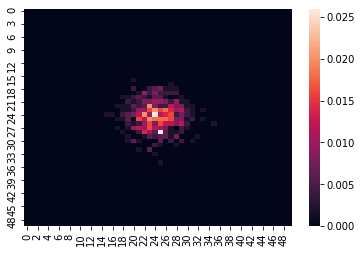

In [111]:
plt.show(sns.heatmap(pd.DataFrame(dataTestHyp[50])))

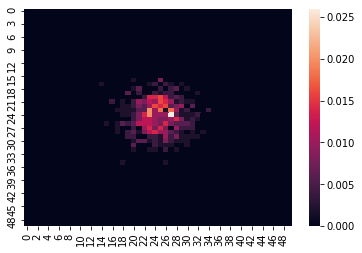

In [112]:
plt.show(sns.heatmap(pd.DataFrame(dataTestAlt[50])))

## Label and shuffle data

In [113]:
trainData = np.row_stack((dataTrainHyp, dataTrainAlt))
trainLabels = np.concatenate( (np.repeat(0, len(dataTrainHyp)),\
                               np.repeat(1, len(dataTrainAlt))), axis=0 )

s = 5
np.random.seed(s)
np.random.shuffle(trainData)
np.random.seed(s)
np.random.shuffle(trainLabels)


testData = np.row_stack((dataTestHyp, dataTestAlt))
testLabels = np.concatenate( (np.repeat(0, len(dataTestHyp)),\
                              np.repeat(1, len(dataTestAlt))), axis=0 ) 

np.random.seed(s)
np.random.shuffle(testData)
np.random.seed(s)
np.random.shuffle(testLabels)

print(trainData.shape)

(44154, 50, 50)


## Make data accessible for other python programs

In [114]:
%store trainData
%store trainLabels

%store testData
%store testLabels

%store t
%store n
%store nmax

Stored 'trainData' (ndarray)
Stored 'trainLabels' (ndarray)
Stored 'testData' (ndarray)
Stored 'testLabels' (ndarray)
Stored 't' (int)
Stored 'n' (int)
Stored 'nmax' (int)
